In [1]:
from PIL.ImageColor import getrgb
import numpy as np

class Palette:
    colors = []  # html color codes
    def __init__(self, colors):
        assert len(colors) == 6
        self.colors = colors
        
    def to_numpy(self):
        numpy_colors = np.array([getrgb(color) for color in self.colors])
        return numpy_colors

In [34]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import os
import requests

def save_image(url, path):
    img_data = requests.get(url).content
    with open(path, 'wb') as handler:
        handler.write(img_data)

def parse_root(root_url="https://www.design-seeds.com/"):
    soup = BeautifulSoup(requests.get(root_url).content, 'html.parser')
    category_urls = []
    for url in [url["href"] if "category" in url["href"] else None for url in soup.find_all("a")]:
        if url:
            category_urls.append(url)
    return category_urls


def parse_category(category_url="https://www.design-seeds.com/category/seasons/summer/"):
    soup = BeautifulSoup(requests.get(category_url).content, 'html.parser')
    design_urls = [elem.find("a")["href"] for elem in soup.find_all(class_="parker-featured-img")]
    return design_urls


def parse_design(design_url="https://www.design-seeds.com/seasons/summer/sweet-hues-7/"):
    soup = BeautifulSoup(requests.get(design_url).content, 'html.parser')
    image_url = soup.find(class_="parker-featured-img").contents[1]["src"]
    colors = [elem.text for elem in  soup.find_all(class_="palette-chips")[0].find_all("li")]
    return image_url, colors


def parse_all():
    if not os.path.exists("data-raw"):
        os.makedirs("data-raw")
    image_paths = []
    palette_paths = []
    
    designs_all = []
    for category_url in tqdm(parse_root()):
        for design_url in parse_category(category_url):
            designs_all.append(parse_design(design_url))
    image_urls = []
    palettes = []
    for image_url, colors in designs_all:
        if not image_url in image_urls:
            image_urls.append(image_url)
            palettes.append(colors)
            
    i = 0
    for image_url, colors in tqdm(zip(image_urls, palettes)):
        if colors:
            assert len(colors) == 6
            palette = Palette(colors)
            save_image(image_url, path=f"data-raw/{i}.jpg")
            np.save(f"data-raw/{i}.npy", palette.to_numpy())
            image_paths.append(f"data-raw/{i}.jpg")
            palette_paths.append(f"data-raw/{i}.npy")
            i += 1
                
    return pd.DataFrame({"image_path": image_paths, "palette_path": palette_paths})

In [35]:
data_raw = parse_all()

100%|██████████| 20/20 [01:25<00:00,  4.28s/it]
88it [01:43,  1.17s/it]


In [16]:
data_raw.to_csv("design-seeds-raw.csv", index=False)

In [17]:
data_raw = pd.read_csv("design-seeds-raw.csv")

In [37]:
data_raw

,image_path,palette_path
0,data-raw/0.jpg,data-raw/0.npy
1,data-raw/1.jpg,data-raw/1.npy
2,data-raw/2.jpg,data-raw/2.npy
3,data-raw/3.jpg,data-raw/3.npy
4,data-raw/4.jpg,data-raw/4.npy
...,...,...
83,data-raw/83.jpg,data-raw/83.npy
84,data-raw/84.jpg,data-raw/84.npy
85,data-raw/85.jpg,data-raw/85.npy
86,data-raw/86.jpg,data-raw/86.npy


In [102]:
import os

import cv2
from PIL import Image
def crop_image(path="data/0.jpg"):
    MIN_PIXELS = 30000
    img = cv2.imread(path)
    if np.prod(img.shape) < MIN_PIXELS:
#             print(np.prod(img.shape), path)
        return None
    if img.shape[0] / img.shape[1] < 1:
        y1_relative = 740 / 1197
        y2_relative = 745 / 1197
        y1 = int(y1_relative * img.shape[1])
        y2 = int(y2_relative * img.shape[1])
        
        y3_relative = 302 / 470
        y4_relative = 307 / 470
        y3 = int(y3_relative * img.shape[1])
        y4 = int(y4_relative * img.shape[1])
        
        if img[:, y1:y2, :].mean() > 254:
            y_cut = int(725 / 1197 * img.shape[1])
            return img[:, :y_cut, :]
        elif img[:, y3:y4, :].mean() > 254:
            y_cut = int(300 / 740 * img.shape[1])
            return img[:, :y_cut, :]
        else:
            print(path)
            return None
    else:
        y1_relative = 800 / 1307
        y2_relative = 805 / 1307
        y1 = int(y1_relative * img.shape[0])
        y2 = int(y2_relative * img.shape[0])
        
        y3_relative = 268 / 436
        y4_relative = 272 / 436
        y3 = int(y3_relative * img.shape[0])
        y4 = int(y4_relative * img.shape[0])
        
        if img[y1:y2, :, :].mean() > 254:
            y_cut = int(795 / 1307 * img.shape[0])
            return img[:y_cut, :, :]
        elif img[y3:y4, :, :].mean() > 254:
            y_cut = int(265 / 436 * img.shape[0])
            return img[:y_cut, :, :]
        else:
            print(path)
            return None
    
def crop_images(data_raw):
    image_paths = []
    palettes = []
    if not os.path.exists("data"):
        os.makedirs("data")
    i = 0
    for _, row in tqdm(data_raw.iterrows()):
        img = crop_image(row["image_path"])
        if img is not None:
            cv2.imwrite(f"data/{i}.jpg", img)
            np.save(f"data/{i}.npy", np.expand_dims(np.load(row["palette_path"]), 0))
            image_paths.append(f"data/{i}.jpg")
            palettes.append(f"data/{i}.npy")
            i += 1
            
    return pd.DataFrame({"image_path": image_paths, "palette_path": palettes})

In [103]:
data = crop_images(data_raw)

88it [00:03, 26.91it/s]


In [104]:
data.to_csv("design-seeds.csv", index=False)

In [105]:
data = pd.read_csv("design-seeds.csv")

In [106]:
data.head()

,image_path,palette_path
0,data/0.jpg,data/0.npy
1,data/1.jpg,data/1.npy
2,data/2.jpg,data/2.npy
3,data/3.jpg,data/3.npy
4,data/4.jpg,data/4.npy


In [107]:
from matplotlib import pyplot as plt
def viz_image(image_path, palette_path):
    """
    visualize image
    visualize palette (using image_to_palette)
    """
    # visualize image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    
    # visualize color palette
    palette = np.load(palette_path)
    plt.imshow(palette)
    # print(palette.shape)
    plt.axis('off')
    plt.show()

    return

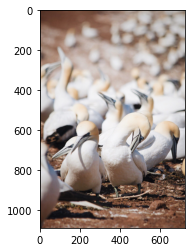

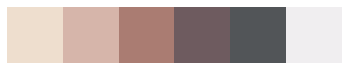

In [108]:
viz_image(data["image_path"].iloc[0], data["palette_path"].iloc[0])

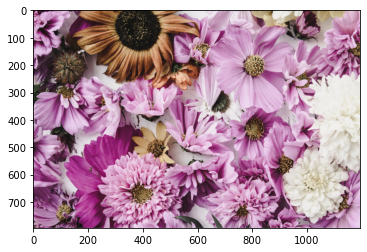

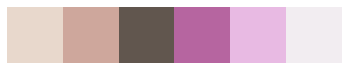

In [109]:
viz_image(data["image_path"].iloc[1], data["palette_path"].iloc[1])

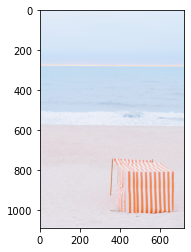

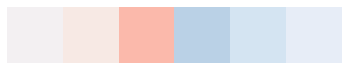

In [110]:
viz_image(data["image_path"].iloc[3], data["palette_path"].iloc[3])

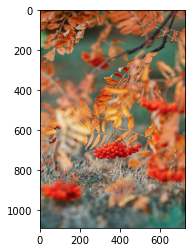

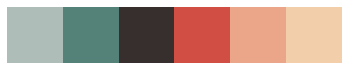

In [111]:
viz_image(data["image_path"].iloc[4], data["palette_path"].iloc[4])

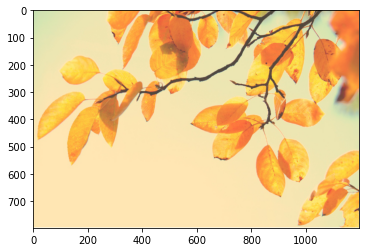

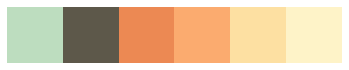

In [112]:
viz_image(data["image_path"].iloc[5], data["palette_path"].iloc[5])